In [1]:
import pyemu
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import geostat_helpers as gh
import pandas as pd
from scipy.stats.mstats import normaltest
import scipy.stats as sps

# Geostatistics 
### Some definitions from Geoff Bohling http://people.ku.edu/~gbohling/cpe940/Variograms.pdf
> ## “Geostatistics: study of phenomena that vary in space and/or time”
(Deutsch, 2002)


> ## “Geostatistics can be regarded as a collection of numerical techniques that deal with the characterization of spatial attributes, employing primarily random models in a manner similar to the way in which time series analysis characterizes temporal data.”
(Olea, 1999)


> ## “Geostatistics offers a way of describing the spatial continuity of natural phenomena and provides adaptations of classical regression techniques to take advantage of this continuity.” 
(Isaaks and Srivastava, 1989)


> ## Geostatistics deals with spatially _autocorrelated_ data.

> ## Autocorrelation: correlation between elements of a series and others from the same series separated from them by a given interval. 
(Oxford American Dictionary)

# Main Concepts


## 1. Variogram modeling -- a way to characterize spatial correlation
## 2. Kriging -- a best linear unbiased estimate (BLUE) for interpolation with minimum variance. There are several flavors - we will focus on Ordinary Kriging
## 3. Stochastic Simulation -- http://petrowiki.org/Geostatistical_conditional_simulation
## 4. Beyond this multi-Gaussian approach focused on the relationships among pairs of points, there is _multiple point geostatistics_ as well using training images and more complex shapes

# These concepts each build on each other. We will briefly touch on the first two

## let's cook up a quick random field and explore the spatial structure

In [2]:
X,Y,Z,v,gs,sample_df = gh.data_cooker()

Initializing a variogram model
Making the domain
Initializing covariance model
Drawing from the Geostatistical Model


## Pretend (key word!) that this is a hydraulic conductivity field

## Any _autocorrelation_ here?

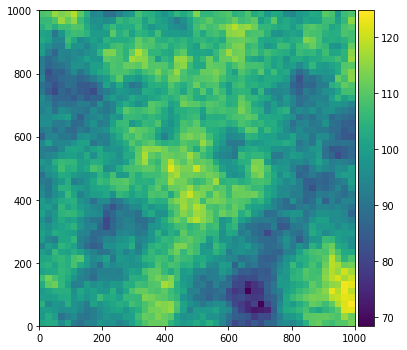

In [3]:
gh.grid_plot(X,Y,Z)

## Of course, we would typically only know the values at a few points 
## (and probably not perfectly)
## N.B. --> The default number of samples used here is 50

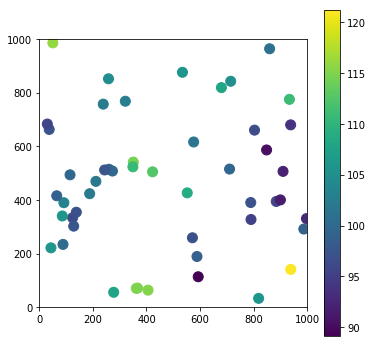

In [4]:
gh.field_scatterplot(sample_df.x,sample_df.y,sample_df.z)

====================================

# Geostatistics is based on a couple main assumptions:
   ## 1. The values are second order stationary (the mean and variance are relatively constant) 
   ## 2. The values are multi-Gaussian (e.g. normally distributed)

# Are the raw data normally distributed?

### Spoiler alert - this field was generated using a variogram!

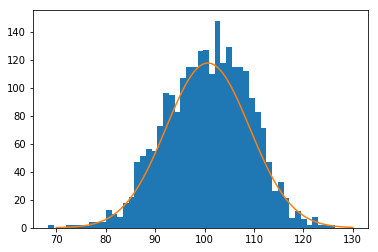

In [5]:
plt.hist(Z.ravel(), bins=50)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(Z),np.std(Z))*len(Z.ravel()))

In [6]:
normaltest(Z.ravel())

NormaltestResult(statistic=14.857556741983842, pvalue=0.00059391260978928931)

# How about our subsample?

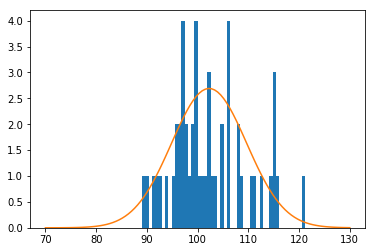

In [7]:
plt.hist(sample_df.z, bins=50)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(sample_df.z),np.std(sample_df.z))*len(sample_df.z))

In [8]:
normaltest(sample_df.z)

NormaltestResult(statistic=2.7548274576724161, pvalue=0.25223004552190581)

# That was a pretty small sample....
## Explore a bigger sample

NormaltestResult(statistic=17.902683594877082, pvalue=0.00012956319579521456)

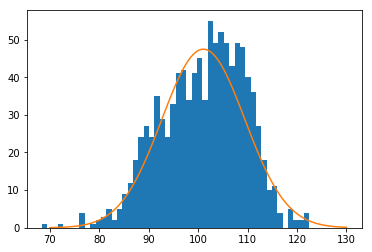

In [9]:
n_sample_pts=1000
xd = np.random.uniform(0, 1000, n_sample_pts)
yd = np.random.uniform(0, 1000, n_sample_pts)
z = gh.sample_from_grid(X,Y,Z,xd,yd)
plt.hist(z, bins=50)
x=np.linspace(70,130,100)
plt.plot(x,sps.norm.pdf(x, np.mean(z),np.std(z))*len(z))
normaltest(z)

## Purity is commendable, but we are going to violate some of these assumptions for sure

====================================

# At the heart of geostatistics is some kind of model expressing the variability of properties in a field

## This is a "variogram" and we can explore it based on the following empirical formula
## $\hat{\gamma}\left(h\right)=\frac{1}{2\left(h\right)}\left(z\left(x_1\right)-z\left(x_2\right)\right)^2$
## where $x_1$ and $x_2$ are the locations of two $z$ data points separated by distance $h$

## If we plot these up we get something called a cloud plot showing $\hat\gamma$ for all pairs in the dataset

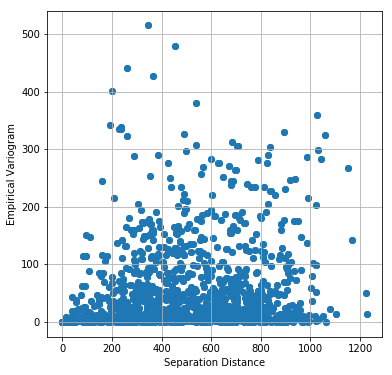

In [10]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,0)

## This is pretty messy, so typically it is evaluated in bins, and usually only over half the total possible distance

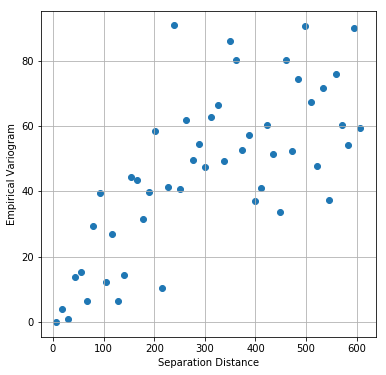

In [11]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,50)

## Also note that this was assuming perfect observations. What if there was ~10% noise?

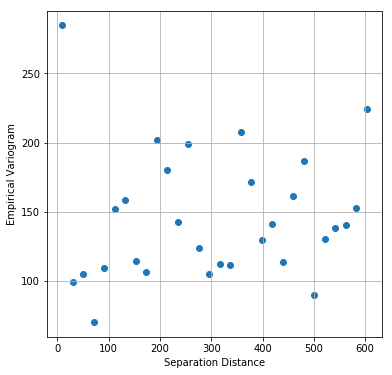

In [12]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z_noisy,30)

## Geostatistics is making the assumption that you can model the variability of this field using a variogram. The variogram is closely related to covariance. 

## We take advantage of a few assumptions to come up with a few functional forms that should characterize this behavior

## `pyemu` supports three variogram models

## This follows the _GSLIB_ terminology

 ## 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 ## 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 ## 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  

     

### $h$ is the separation distance, and $a$ is the range. `contribution` is the variogram value at which the variogram levels off. Also called the `sill`, this value is the maximum variability between points.

### The sill is reached at about $a$ for the *Spherical* model, $2a$ for the *Gaussian*, and $3a$ for the *Exponential*

# What do these look like?

## for a consistent set of parameters:
## a=500, c=10
## We can use `pyemu` to setup a geostatistical model

In [13]:
a=500
c=10

## Set up a variogram object and, from that, build a geostatistical structure

### _Spherical_

In [14]:
v = pyemu.geostats.SphVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)

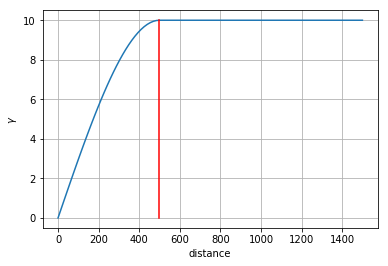

In [16]:
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.grid()

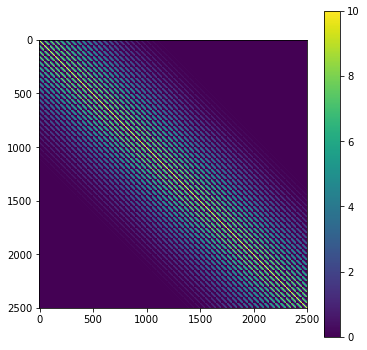

In [17]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()

### _Exponential_

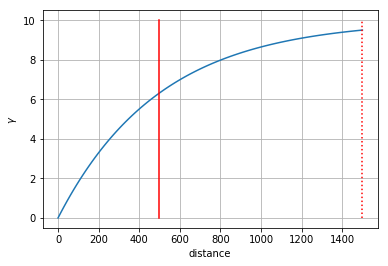

In [18]:
v = pyemu.geostats.ExpVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.plot([3*v.a,3*v.a],[0,v.contribution],'r:')
plt.grid()

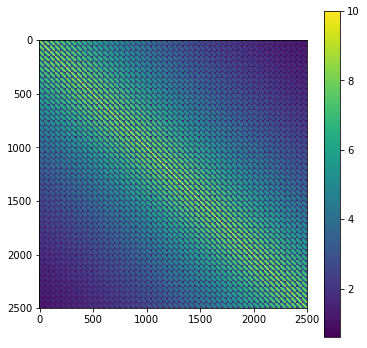

In [19]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()

### _Gaussian_

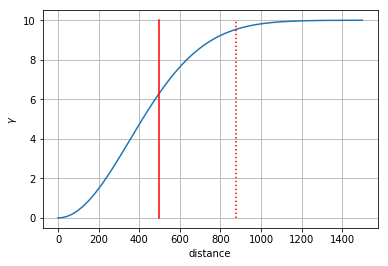

In [20]:
v = pyemu.geostats.GauVario(contribution=c, a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)
gs.plot()
plt.plot([v.a,v.a],[0,v.contribution],'r')
plt.plot([7/4*v.a,7/4*v.a],[0,v.contribution],'r:')
plt.grid()

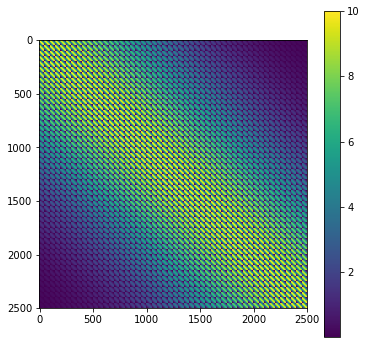

In [21]:
Q= gs.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()

# If we fit an appropriate model ($\gamma$) to the empirical variogram ($\hat\gamma$), we can use that structure for interpolation from sparse data

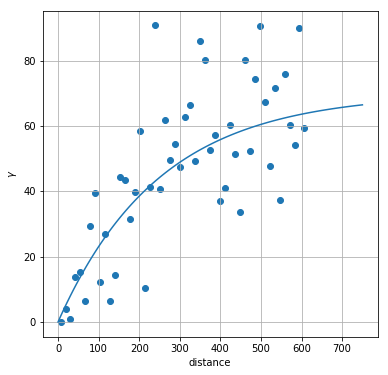

In [22]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z,50)
new_c=70.0
new_a=250.0

v_fit = pyemu.geostats.ExpVario(contribution=new_c,a=new_a)
gs_fit = pyemu.geostats.GeoStruct(variograms=v_fit)
gs_fit.plot(ax=ax)


In [23]:
Q = gs_fit.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar()


# We can perform Kriging to interpolate using this variogram and our "data"

## First make an Ordinary Kriging object

In [ ]:
k = pyemu.geostats.OrdinaryKrige(gs_fit,sample_df)

In [ ]:
sample_df.head()

## Next we need to calculate factors (we only do this once - takes a few seconds)

In [ ]:
kfactors = k.calc_factors(X.ravel(),Y.ravel())

## It's easiest to think of these factors as weights on surrounding point to calculate a weighted average of the surrounding values. The weight is a function of the distance - farther points have smaller weights

In [ ]:
kfactors.head()

In [ ]:
Z_interp = gh.geostat_interpolate(X,Y,k.interp_data, sample_df)

In [ ]:
ax=gh.grid_plot(X,Y,Z_interp,vlims=[80,135], title='reconstruction')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
gh.grid_plot(X,Y,Z,vlims=[80,135],title='truth')

In [ ]:
ax=gh.grid_plot(X,Y,kfactors.err_var.values.reshape(X.shape), title='Variance of Estimate')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
ax=gh.grid_plot(X,Y,np.abs(Z-Z_interp), title='Actual Differences')
ax.plot(sample_df.x,sample_df.y, 'yo')

# What if our data were noisy?

In [ ]:
h,gam,ax=gh.plot_empirical_variogram(sample_df.x,sample_df.y,sample_df.z_noisy,30)
new_c=150.0
new_a=275.0

# select which kind of variogram here because in reality we don't know, right?
v_fit = pyemu.geostats.ExpVario(contribution=new_c,a=new_a)
gs_fit = pyemu.geostats.GeoStruct(variograms=v_fit, nugget=50)
gs_fit.plot(ax=ax)

In [ ]:
Q = gs_fit.covariance_matrix(X.ravel(), Y.ravel(), names=[str(i) for i in range(len(Y.ravel()))])
plt.figure(figsize=(6,6))
plt.imshow(Q.x)
plt.colorbar();

## Again make the Kriging Object and the factors and interpolate

In [ ]:
k = pyemu.geostats.OrdinaryKrige(gs_fit,sample_df)
kfactors = k.calc_factors(X.ravel(),Y.ravel())
Z_interp = gh.geostat_interpolate(X,Y,k.interp_data, sample_df)

In [ ]:
ax=gh.grid_plot(X,Y,Z_interp,vlims=[80,135], title='reconstruction')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
gh.grid_plot(X,Y,Z,vlims=[80,135],title='truth')

In [ ]:
ax=gh.grid_plot(X,Y,kfactors.err_var.values.reshape(X.shape), title='Variance of Estimate')
ax.plot(sample_df.x,sample_df.y, 'ko')

In [ ]:
ax=gh.grid_plot(X,Y,np.abs(Z-Z_interp), title='Actual Differences')
ax.plot(sample_df.x,sample_df.y, 'yo')

# Further resources and information

   # These concepts are used for pilot point interpolation in PEST
   ## a. In the GW utilities in PEST (http://www.pesthomepage.org/Groundwater_Utilities.php) 
   ## b. The main tools are also available in `pyemu` -- we'll use that in the class

# A nice but outdated set of references is at: http://people.ku.edu/~gbohling/geostats/

# The Stanford Geostatistical Modeling Software (SGeMS: http://sgems.sourceforge.net/) is a nice GUI for geostatistical modeling, but it's not being maintained anymore.

# `R` has a package: http://rgeostats.free.fr/

# Some packages are under development in `python` but not very far along. 

# `QGIS` and `ArcGIS` have some geostatistical modeling capabilities as well